In [ ]:
# !pip install tensorflow==2.4.1 opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard


In [2]:
mp_holistic = mp.solutions.holistic          #Holistic Model Class
mp_drawing = mp.solutions.drawing_utils      # Drawing Utilities Class

In [3]:
def mediapipe_detection(image, model):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)                    # Make Prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    return image, results



In [4]:
def draw_landmarks(image,results):
    
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)


# Test Camera Capture

In [5]:
cap = cv2.VideoCapture(0)

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    
    while cap.isOpened():
        
        #Read Frame
        ret, frame = cap.read()

        #Make Detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)


        #Draw Landmarks
        draw_landmarks(image,results)
        
        
        #Print to Screen
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1);


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [6]:
draw_landmarks(frame, results)

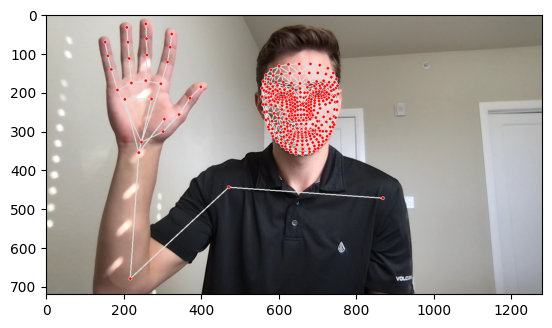

In [7]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() \
    if results.pose_landmarks else np.zeros(33*4)
    
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() \
    if results.left_hand_landmarks else np.zeros(21*3)
    
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() \
    if results.right_hand_landmarks else np.zeros(21*3)
    
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() \
    if results.face_landmarks else np.zeros(468*3)
    
    return np.concatenate([pose, face, lh , rh])

In [10]:
extract_keypoints(results).shape

(1662,)

# Create Directories

In [9]:
DATA_PATH = os.path.join('MP_Data')
actions = np.array(['Hello','NiceToMeetYou','Thanks','GoodBye'])
no_sequences = 60
sequence_length = 30

# Collect Data

In [ ]:
cap = cv2.VideoCapture(0)

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                
        
                #Read Frame
                ret, frame = cap.read()

                #Make Detections
                image, results = mediapipe_detection(frame, holistic)
                #print(results)


                #Draw Landmarks
                draw_landmarks(image,results)

                
                #Collection logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
                    cv2.putText(image, 'COLLECTING FRAMES FOR {} VIDEO NUMBER {}'.format(action,sequence) , (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)   
                    cv2.waitKey(2000)
                    
                else:
                    cv2.putText(image, 'COLLECTING FRAMES FOR {} VIDEO NUMBER {}'.format(action,sequence) , (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA) 
                
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
            
            
                #Print to Screen
                cv2.imshow('OpenCV Feed', image)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1);


# Second Round of Data Collection

In [ ]:
cap = cv2.VideoCapture(0)

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    
    for action in ['GoodBye']:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                
        
                #Read Frame
                ret, frame = cap.read()

                #Make Detections
                image, results = mediapipe_detection(frame, holistic)
                #print(results)


                #Draw Landmarks
                draw_landmarks(image,results)

                
                #Collection logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
                    cv2.putText(image, 'COLLECTING FRAMES FOR {} VIDEO NUMBER {}'.format(action,sequence) , (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)   
                    cv2.waitKey(2000)
                    
                else:
                    cv2.putText(image, 'COLLECTING FRAMES FOR {} VIDEO NUMBER {}'.format(action,sequence) , (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA) 
                
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
            
            
                #Print to Screen
                cv2.imshow('OpenCV Feed', image)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1);


# Preprocess Data

In [12]:
label_map = {label : num for num, label in enumerate(actions)}

In [13]:
label_map

{'Hello': 0, 'NiceToMeetYou': 1, 'Thanks': 2, 'GoodBye': 3}

In [14]:
sequences, labels = [],[]
for action in actions:
    for sequence in range(60):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), '{}.npy'.format(frame_num))) #Load in the saved numpy arrays from earlier
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [15]:
X = np.array(sequences)

In [16]:
y = np.array(labels)

In [17]:
print(X.shape)
print(y.shape)

(240, 30, 1662)
(240,)


In [18]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True, random_state = 14)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size = 0.1, shuffle = True, random_state = 14)

In [20]:
X_train.shape

(194, 30, 1662)

In [21]:
X_val.shape

(22, 30, 1662)

In [22]:
X_test.shape

(24, 30, 1662)

In [23]:
y_train.shape

(194,)

In [24]:
y_val.shape

(22,)

In [25]:
y_test.shape

(24,)

# Build and Train Model

In [ ]:
#log_dir = os.path.join('Logs')
#tb_callback = TensorBoard(log_dir = log_dir)

In [26]:
tf.random.set_seed(46)
model = Sequential()
model.add(LSTM(64, return_sequences = True, activation = 'relu', input_shape = (30, 1662)))
model.add(LSTM(128, return_sequences = True, activation = 'relu'))
model.add(LSTM(64, return_sequences = False, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(actions.shape[0], activation = 'softmax'))

2022-11-07 19:18:46.725118: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-07 19:18:46.725362: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            442112    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 596,708
Trainable params: 596,708
Non-trainable params: 0
__________________________________________________

In [28]:
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [29]:
model.fit(X_train, y_train, epochs = 500, validation_data = (X_val, y_val), batch_size = 194) #callbacks = tb_callback, ,  validation_split = 0.1 OR validation_data = (X_val, y_val)

2022-11-07 19:18:47.271534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 1.3872 - accuracy: 0.3608 - val_loss: 3.6553 - val_accuracy: 0.1364
Epoch 2/500
1/1 [==============================] - 0s 216ms/step - loss: 2.7823 - accuracy: 0.2680 - val_loss: 1.4165 - val_accuracy: 0.3636
Epoch 3/500
1/1 [==============================] - 0s 221ms/step - loss: 1.3873 - accuracy: 0.3711 - val_loss: 1.8229 - val_accuracy: 0.0000e+00
Epoch 4/500
1/1 [==============================] - 0s 218ms/step - loss: 1.7000 - accuracy: 0.0464 - val_loss: 1.5319 - val_accuracy: 0.1364
Epoch 5/500
1/1 [==============================] - 0s 232ms/step - loss: 1.4408 - accuracy: 0.2680 - val_loss: 1.4275 - val_accuracy: 0.1364
Epoch 6/500
1/1 [==============================] - 0s 221ms/step - loss: 1.3855 - accuracy: 0.2680 - val_loss: 1.4854 - val_accuracy: 0.1364
Epoch 7/500
1/1 [==============================] - 0s 215ms/step - loss: 1.4063 - accuracy: 0.2680 - val_loss: 2.6703 - val_accuracy: 0.1364
Epoch 8/500


Epoch 59/500
1/1 [==============================] - 0s 239ms/step - loss: 0.8584 - accuracy: 0.5876 - val_loss: 0.8219 - val_accuracy: 0.5000
Epoch 60/500
1/1 [==============================] - 0s 231ms/step - loss: 0.8369 - accuracy: 0.5567 - val_loss: 0.8160 - val_accuracy: 0.4545
Epoch 61/500
1/1 [==============================] - 0s 237ms/step - loss: 0.8205 - accuracy: 0.5258 - val_loss: 0.8140 - val_accuracy: 0.4545
Epoch 62/500
1/1 [==============================] - 0s 242ms/step - loss: 0.8075 - accuracy: 0.5206 - val_loss: 0.8008 - val_accuracy: 0.5000
Epoch 63/500
1/1 [==============================] - 0s 238ms/step - loss: 0.7829 - accuracy: 0.5515 - val_loss: 0.7739 - val_accuracy: 0.5000
Epoch 64/500
1/1 [==============================] - 0s 228ms/step - loss: 0.7489 - accuracy: 0.5670 - val_loss: 0.7008 - val_accuracy: 0.5455
Epoch 65/500
1/1 [==============================] - 0s 226ms/step - loss: 0.6956 - accuracy: 0.6546 - val_loss: 0.6105 - val_accuracy: 0.8636
Epoch 

1/1 [==============================] - 0s 259ms/step - loss: 0.0487 - accuracy: 0.9897 - val_loss: 0.0592 - val_accuracy: 0.9545
Epoch 174/500
1/1 [==============================] - 0s 259ms/step - loss: 0.0433 - accuracy: 0.9948 - val_loss: 0.0994 - val_accuracy: 0.9545
Epoch 175/500
1/1 [==============================] - 0s 251ms/step - loss: 0.0377 - accuracy: 0.9897 - val_loss: 0.1339 - val_accuracy: 0.9545
Epoch 176/500
1/1 [==============================] - 0s 274ms/step - loss: 0.0357 - accuracy: 0.9897 - val_loss: 0.1275 - val_accuracy: 0.9545
Epoch 177/500
1/1 [==============================] - 0s 258ms/step - loss: 0.0288 - accuracy: 0.9897 - val_loss: 0.1298 - val_accuracy: 0.9545
Epoch 178/500
1/1 [==============================] - 0s 245ms/step - loss: 0.0197 - accuracy: 0.9897 - val_loss: 0.1142 - val_accuracy: 0.9545
Epoch 179/500
1/1 [==============================] - 0s 248ms/step - loss: 0.0118 - accuracy: 0.9948 - val_loss: 0.0409 - val_accuracy: 0.9545
Epoch 180/500

1/1 [==============================] - 0s 304ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0897 - val_accuracy: 0.9545
Epoch 288/500
1/1 [==============================] - 0s 314ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0984 - val_accuracy: 0.9545
Epoch 289/500
1/1 [==============================] - 0s 266ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0690 - val_accuracy: 0.9545
Epoch 290/500
1/1 [==============================] - 0s 272ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0366 - val_accuracy: 0.9545
Epoch 291/500
1/1 [==============================] - 0s 258ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 1.0000
Epoch 292/500
1/1 [==============================] - 0s 251ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 1.0000
Epoch 293/500
1/1 [==============================] - 0s 257ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 294/500

Epoch 399/500
1/1 [==============================] - 0s 246ms/step - loss: 1.8512e-04 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.9545
Epoch 400/500
1/1 [==============================] - 0s 250ms/step - loss: 1.8352e-04 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.9545
Epoch 401/500
1/1 [==============================] - 0s 244ms/step - loss: 1.8195e-04 - accuracy: 1.0000 - val_loss: 0.0775 - val_accuracy: 0.9545
Epoch 402/500
1/1 [==============================] - 0s 245ms/step - loss: 1.8040e-04 - accuracy: 1.0000 - val_loss: 0.0775 - val_accuracy: 0.9545
Epoch 403/500
1/1 [==============================] - 0s 250ms/step - loss: 1.7886e-04 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.9545
Epoch 404/500
1/1 [==============================] - 0s 250ms/step - loss: 1.7733e-04 - accuracy: 1.0000 - val_loss: 0.0773 - val_accuracy: 0.9545
Epoch 405/500
1/1 [==============================] - 0s 260ms/step - loss: 1.7583e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 455/500
1/1 [==============================] - 0s 278ms/step - loss: 1.1860e-04 - accuracy: 1.0000 - val_loss: 0.0792 - val_accuracy: 0.9545
Epoch 456/500
1/1 [==============================] - 0s 270ms/step - loss: 1.1773e-04 - accuracy: 1.0000 - val_loss: 0.0795 - val_accuracy: 0.9545
Epoch 457/500
1/1 [==============================] - 0s 273ms/step - loss: 1.1689e-04 - accuracy: 1.0000 - val_loss: 0.0796 - val_accuracy: 0.9545
Epoch 458/500
1/1 [==============================] - 0s 288ms/step - loss: 1.1605e-04 - accuracy: 1.0000 - val_loss: 0.0797 - val_accuracy: 0.9545
Epoch 459/500
1/1 [==============================] - 0s 301ms/step - loss: 1.1522e-04 - accuracy: 1.0000 - val_loss: 0.0796 - val_accuracy: 0.9545
Epoch 460/500
1/1 [==============================] - 0s 277ms/step - loss: 1.1439e-04 - accuracy: 1.0000 - val_loss: 0.0795 - val_accuracy: 0.9545
Epoch 461/500
1/1 [==============================] - 0s 292ms/step - loss: 1.1358e-04 - accuracy: 1.0000 - val_loss: 0

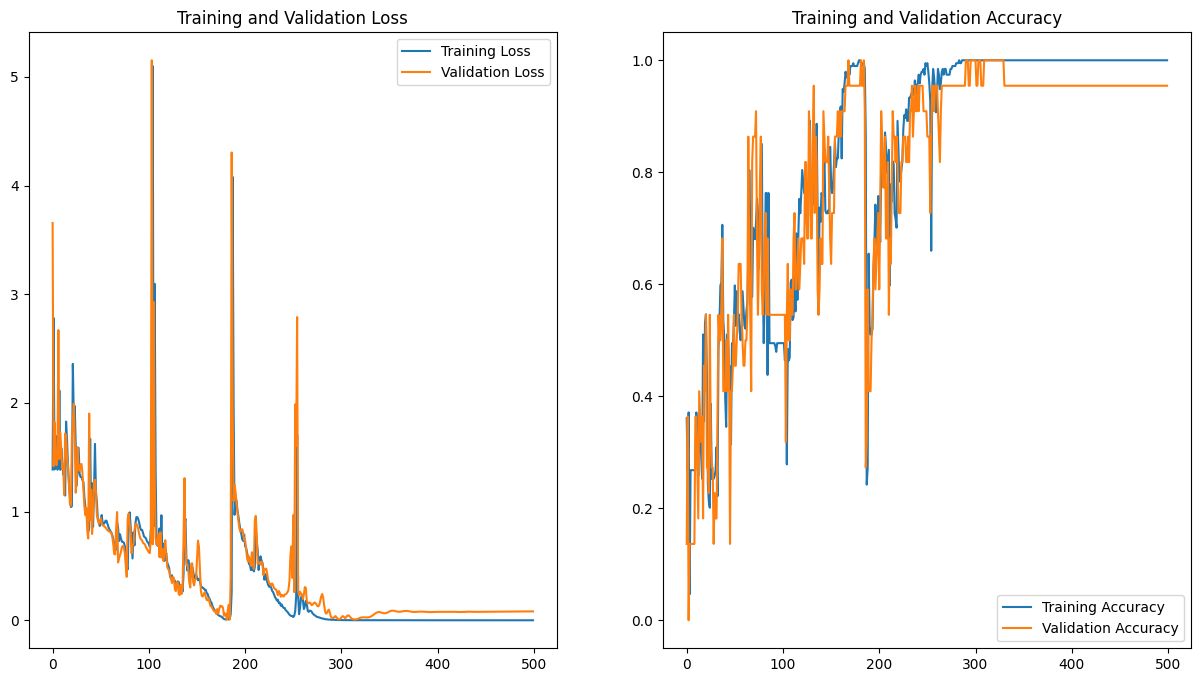

In [30]:
results = model.history

acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

epochs_range = range(len(results.history['accuracy']))

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.ylim(0,5)
plt.show()

In [31]:
y_pred = [np.argmax(pred) for pred in model.predict(X_test)]
y_pred

[3, 0, 0, 0, 1, 1, 2, 2, 3, 0, 1, 1, 0, 2, 2, 0, 3, 1, 0, 3, 2, 3, 1, 1]

In [32]:
y_test

array([3, 0, 0, 0, 1, 1, 2, 2, 3, 0, 1, 1, 0, 2, 2, 0, 3, 1, 0, 3, 2, 3,
       1, 1])

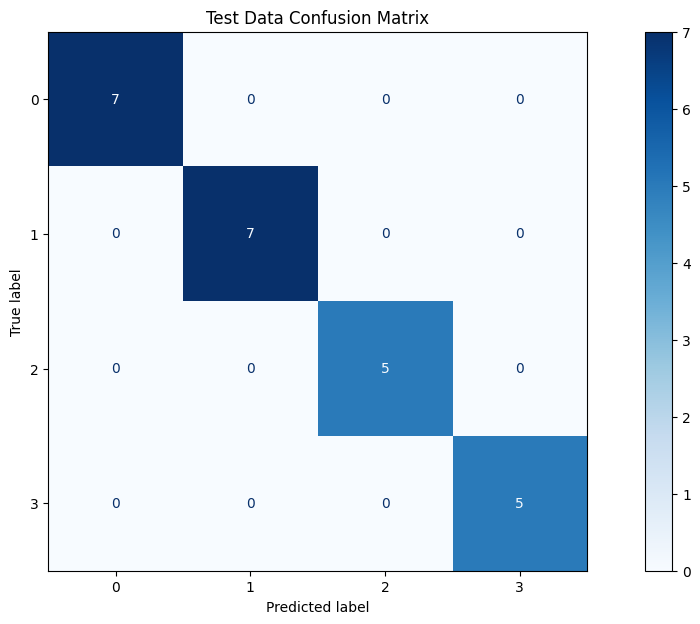

In [33]:
fig, ax = plt.subplots(figsize = (15,7))
ax.set_title('Test Data Confusion Matrix')

labels = actions

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues, ax = ax);

In [34]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 35ms/step - loss: 0.0267 - accuracy: 1.0000


[0.026731304824352264, 1.0]

# Saving and Rebuilding Model

In [ ]:
# model.save('action_final.h5')

In [ ]:
# Now, to rebuild: 

# 1) Create model (reconstructed_model = Sequential...)

# 2) Compile Model (reconstructed_model.compile...)

# 3) Load Weights (reconstructed_model.load_weights('action.h5') )

#EX:

In [15]:
model = Sequential()
model.add(LSTM(64, return_sequences = True, activation = 'relu', input_shape = (30, 1662)))
model.add(LSTM(128, return_sequences = True, activation = 'relu'))
model.add(LSTM(64, return_sequences = False, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(actions.shape[0], activation = 'softmax'))

In [16]:
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [17]:
model.load_weights('action_final.h5')

In [18]:
model.evaluate(X_test, y_test)

NameError: name 'X_test' is not defined

# Testing in Real Time

In [29]:
# New variables

sequence = []
sentence = []
predictions = []
threshold = 0.9

cap = cv2.VideoCapture(0)

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    
    while cap.isOpened():
        
        #Read Frame
        ret, frame = cap.read()

        #Make Detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)


        #Draw Landmarks
        #draw_landmarks(image,results)
        
        
        #Predictions
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis = 0))[0] #Expand dims to only predict a single image shape(1, 30, 1662)
            predictions.append(np.argmax(res))
            
            
            #Visualize Phrases
            #if np.unique(predictions[-10:])[0] == np.argmax(res):
            if np.sum(predictions[-15:]) == np.argmax(res) * 15:
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]
            
        #cv2.rectangle(image, (0, 0), (1000, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (1, 1, 255), 2, cv2.LINE_AA)
        
        
        #Print to Screen
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1);